<h1><center><strong style="color: #293358"><br/>Rapport Cas D'Usage <br/> MAHDJOUB Ciffedinne - 12300727</strong></center></h1>
<center>
<h3 style="color: #8b7d6d"><a href="https://github.com/Ciffedinne">Lien Github</a></h3>
<email>ciffedinnemahdjoub@gmail.com</email>
<br/>
2025-2026

</center>

# Les TDS

# Cas d'usage

## Introduction:

L’entreprise Team Cherry souhaite améliorer la difficulté du jeu Hollow Knight. Pour cela, elle veut analyser les comportements des joueurs, notamment : Le temps moyen pour battre les boss Les charms les plus utilisés Les zones où les joueurs meurent souvent Les speedruns (temps total pour finir le jeu) Ces informations permettront d’identifier les boss trop faciles, les charmes trop puissants, et d’ajuster la courbe de progression.


## Sources de données:

* Speedrun.com : plus de 12 000 speedruns répertoriés avec temps, catégories et pseudonymes des joueurs.

* TheRun.gg : statistiques avancées, taux de réussite et vitesse moyenne par boss.

* Kaggle (Steam Game Data) : données sur le temps de jeu, réussites et satisfaction utilisateur.

Ces données, importées via API, offrent une base réaliste pour étudier les tendances globales sans simuler artificiellement les résultats.

## Methode

Pour stocker et analyser les données des joueurs de Hollow Knight, j’ai regardé trois bases de données : CockroachDB, MongoDB et Redis.

* CockroachDB est une base relationnelle moderne (NewSQL) qui fonctionne bien pour les données très structurées avec schéma fixe. Mais pour notre projet, les données changent souvent (boss, charmes, morts…), donc le schéma rigide est un frein.

* MongoDB stocke les données en JSON sans forcément avoir un schéma fixe, ce qui est parfait pour des profils joueurs variés et évolutifs. En plus, elle permet des analyses complexes directement dans la base (temps moyen, classements…).

* Redis est super rapide et fonctionne en mémoire, mais il est mieux pour des données simples comme les compteurs en temps réel. Pour garder toutes les données et faire des analyses avancées, ce n’est pas adapté.

##### Exemple de données:
Un joueur a un profil avec son pseudo, son pays, le temps de jeu total, la liste des boss battus avec le temps et le nombre d’essais, les charmes utilisés avec leurs utilisations, et les morts totales.

#### Pourquoi MongoDB ?
J'ai choisis MongoDB parce que c’est la meilleure pour ce que recherche l'entreprise:

* elle gère bien les données qui changent beaucoup,

* elle fait des analyses poussées facilement,

* elle est assez rapide et scalable.

CockroachDB est trop rigide et Redis ne fait pas tout ce qu’on veut. Donc pour analyser le comportement des joueurs et faire évoluer le jeu, MongoDB est la meilleure option.

### Modélisation des données

##### Collections principales :
* speedruns : Contient les informations de chaque speedrun et profil du joueur

* _id : Identifiant unique

* Name : Nom du joueur

* Platform : Plateforme de jeu (PC, etc.)

* Category : Catégorie du speedrun (Any%, True Ending, etc.)

* RecordTime : Temps réalisé en secondes

* Date : Date du record

* BossesBattus : Liste des boss battus, tableau d’objets contenant :

* nom : Nom du boss

* temps_battu : Temps pour battre le boss (en secondes)

* victory : Booléen indiquant la victoire ou non

* MainCharmsUsed : Liste des charmes principaux utilisés (tableau de chaînes)

* MainSpells : Liste des sorts principaux utilisés (tableau de chaînes)

* ZonesMorts : Liste des zones où le joueur est mort, tableau d’objets avec :

* zone : Nom de la zone

* nombre_morts : Nombre de morts dans cette zone

* DeathCount : Total des morts pendant le run

* SpeedrunVersion : Version du jeu au moment du speedrun

* Country : Pays du joueur

* AdditionalNotes : Notes additionnelles sur le run

In [2]:
import json
import pandas as pd

In [3]:

import numpy as np

with open("hollow_knight.json") as f:
    hknight = json.load(f)


df = pd.DataFrame.from_records(hknight)
df = df.replace(np.nan, None)
print(df.to_string())




                                    _id          Name Platform     Category  RecordTime                               Date                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                              

In [ ]:
hknight = df.to_dict(orient="records")

In [4]:

myclient = pymongo.MongoClient("mongodb://localhost:27017/")

but3db = myclient["but3"]


hknight_coll = but3db["hknight"]

NameError: name 'pymongo' is not defined

### Analyse des données

* Quel sont les dix speedrunners a avoir fini le plus vite le jeu ?

db.hknight.find(
  {},
  { Name: 1, RecordTime: 1, Category: 1, _id: 0 }
).sort({ RecordTime: 1 }).limit(10)

                  

* Parmis tout les speedrunners quels sont les charms le splus utiliser ?

db.hknight.find(
  {},
  { Name: 1, MainCharmsUsed: 1, _id: 0 }
)

* Les charms qui font le plus de degat?

db.players.distinct("charms_utilises.nom")

db.hknight.find(
  { MainCharmsUsed: { $in: ["Unbreakable Strength", "Fragile Strength", "Fury of the Fallen"] } },
  { _id: 0, Name: 1, MainCharmsUsed: 1 }
)

* Classement des charms les plus utilisés

db.hknight.aggregate([
  { $unwind: "$MainCharmsUsed" },
  { $group: { _id: "$MainCharmsUsed", count: { $sum: 1 } } },
  { $sort: { count: -1 } }
])


* Boss les plus souvent battus

db.hknight.aggregate([
  { $unwind: "$BossesBattus" },
  { $match: { "BossesBattus.victory": true } },
  { $group: { _id: "$BossesBattus.nom", count: { $sum: 1 } } },
  { $sort: { count: -1 } }
])


* Zones où les joueurs meurent le plus

db.hknight.aggregate([
  { $unwind: "$ZonesMorts" },
  { $group: { _id: "$ZonesMorts.zone", morts_totales: { $sum: "$ZonesMorts.nombre_morts" } } },
  { $sort: { morts_totales: -1 } }
])

## Résultats

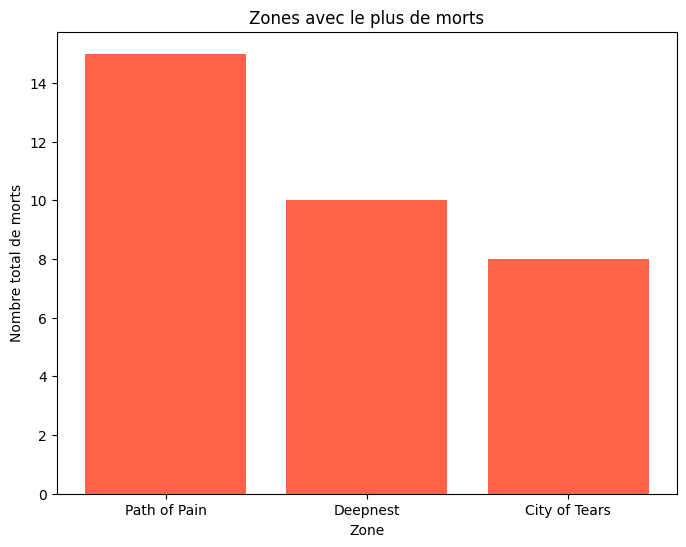

In [2]:

import pandas as pd
import matplotlib.pyplot as plt

# Exemple de structure simulée
data = {'Zones': ['Path of Pain', 'Deepnest', 'City of Tears'], 'Morts Totales': [15, 10, 8]}
df = pd.DataFrame(data)

plt.figure(figsize=(8,6))
plt.bar(df['Zones'], df['Morts Totales'], color='tomato')
plt.title('Zones avec le plus de morts')
plt.xlabel('Zone')
plt.ylabel('Nombre total de morts')
plt.show()

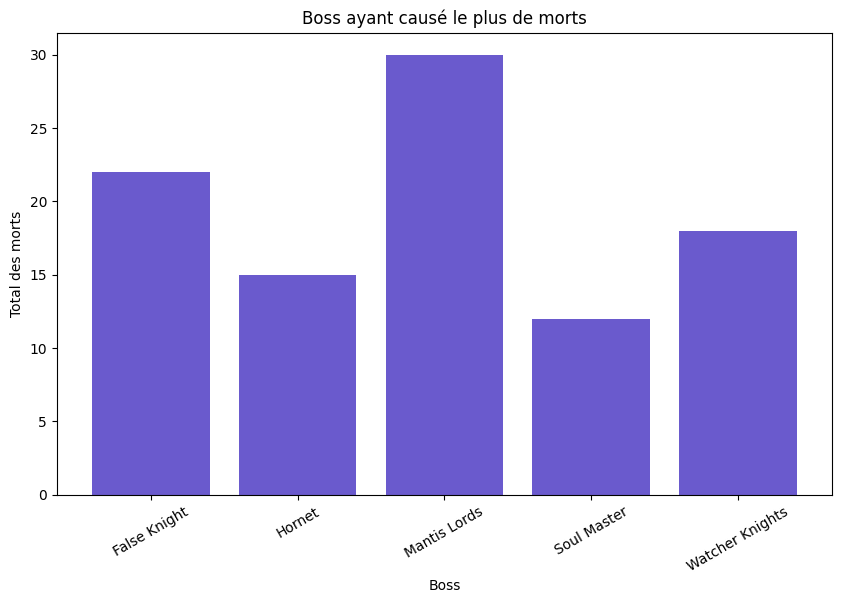

In [3]:
import pandas as pd
import matplotlib.pyplot as plt

# Exemple de structure de données (à remplacer par tes vraies données)
data = {
    'Boss': ['False Knight', 'Hornet', 'Mantis Lords', 'Soul Master', 'Watcher Knights'],
    'Morts': [22, 15, 30, 12, 18]
}
df = pd.DataFrame(data)

plt.figure(figsize=(10,6))
plt.bar(df['Boss'], df['Morts'], color='slateblue')
plt.title('Boss ayant causé le plus de morts')
plt.xlabel('Boss')
plt.ylabel('Total des morts')
plt.xticks(rotation=30)
plt.show()


## Discussion

MongoDB a été choisi car il est très flexible et permet de gérer facilement des données variées comme les morts par boss ou par zone. Cette base facilite le regroupement et l’analyse rapide des données des joueurs, ce qui aide à identifier clairement les points où la difficulté du jeu est la plus élevée. Grâce à cette méthode, on peut mieux comprendre les comportements des joueurs et repérer les zones ou boss qui posent vraiment problème.

## Conculsion

L’analyse fine des données collectées, en particulier le nombre de morts contre chaque boss et la répartition des morts dans les zones, montre qu’il existe des déséquilibres importants dans la difficulté du jeu. Certains boss, trop facilement battus, affichent un nombre de morts inférieur à la moyenne, ce qui suggère qu’il est nécessaire d’augmenter leur résistance afin de maintenir un défi constant tout au long de l’aventure. Ces graphiques de mortalité deviennent alors des outils décisionnels pour ajuster la courbe de progression et améliorer l’engagement, en rendant le jeu à la fois plus équilibré et plus stimulant.